## Setup

In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import pandas as pd
import time

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import (
    EffectiveAreaTable2D,
    EnergyDispersion2D,
    EnergyDependentMultiGaussPSF,
    Background3D,
)
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap
from gammapy.spectrum import models
from gammapy.image.models import SkyPointSource
from gammapy.cube.models import SkyModel
from gammapy.cube import MapFit, MapEvaluator, PSFKernel
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf

from gammapy.astro.darkmatter import PrimaryFlux
from gammapy.utils.fitting import Parameter, Parameters

## Load IRFs

In [3]:
def get_irfs():
    """Load CTA IRFs"""
    filename = "$CTADATA/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
    psf = EnergyDependentMultiGaussPSF.read(
        filename, hdu="POINT SPREAD FUNCTION"
    )
    aeff = EffectiveAreaTable2D.read(filename, hdu="EFFECTIVE AREA")
    edisp = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
    bkg = Background3D.read(filename, hdu="BACKGROUND")
    return dict(psf=psf, aeff=aeff, edisp=edisp, bkg=bkg)
irfs = get_irfs()

## Derive ancillary IRF maps 

**Define map geometry**

In [4]:
GLON = 96.34 * u.Unit("deg")
GLAT = -60.19 * u.Unit("deg")
src_pos = SkyCoord(GLON, GLAT, frame="galactic")
emin = 0.03 * u.Unit("GeV")
emax = 100 * u.Unit("GeV")
lg_emin = np.log10(emin.value)
lg_emax = np.log10(emax.value)
ENERGY_BINS = 30

In [5]:
axis = MapAxis.from_edges(
    np.logspace(lg_emin, lg_emax, ENERGY_BINS),
    unit="TeV",
    name="energy",
    interp="log",
)
geom = WcsGeom.create(
    skydir=src_pos, binsz=0.02, width=(2, 2), coordsys="GAL", axes=[axis]
)

**Declare observation values**

In [7]:
pointing = src_pos
livetime = 50 * u.hour
offset = 2 * u.deg

**Build maps**

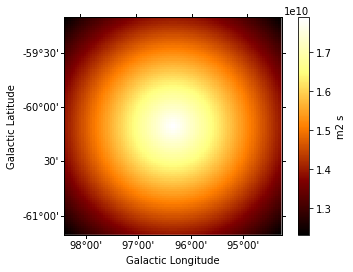

In [8]:
exposure = make_map_exposure_true_energy(
    pointing=pointing, livetime=livetime, aeff=irfs["aeff"], geom=geom
)
exposure.slice_by_idx({"energy": 3}).plot(add_cbar=True);

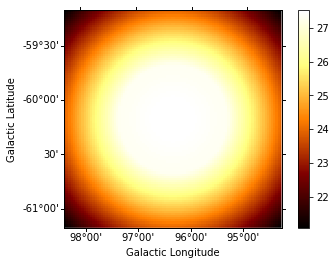

In [9]:
background = make_map_background_irf(
    pointing=pointing, ontime=livetime, bkg=irfs["bkg"], geom=geom
)
background.slice_by_idx({"energy": 3}).plot(add_cbar=True);

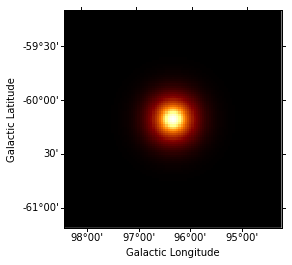

In [10]:
psf = irfs["psf"].to_energy_dependent_table_psf(theta=offset)
psf_kernel = PSFKernel.from_table_psf(psf, geom, max_radius=1 * u.deg)
psf_kernel.psf_kernel_map.sum_over_axes().plot(stretch="log");

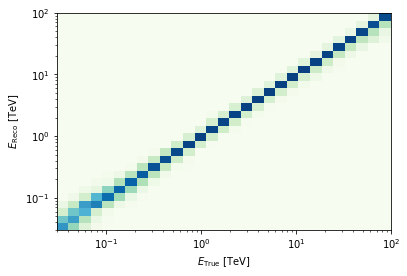

In [11]:
edisp = irfs["edisp"].to_energy_dispersion(
    offset=offset, e_reco=axis.edges * axis.unit, e_true=axis.edges * axis.unit
)
edisp.plot_matrix();

## Build model

**Declare constants and parameters for our DM model**

In [12]:
PI8 = 8 * np.pi
THERMAL_RELIC_CROSS_SECTION = 3e-26 * u.Unit("cm3 s-1")
JFAC = 3.41e19 * u.Unit("GeV2 cm-5") # <--- point source / may be also a 2D map
mDM = 5000*u.Unit("GeV")
channel_list = ["b"] 

**Fetch Primary Flux**

https://docs.gammapy.org/0.10/notebooks/astro_dark_matter.html

In [13]:
dNdE = PrimaryFlux(mDM, channel=channel_list[0])

**Define Spectral User Model**

https://docs.gammapy.org/0.10/notebooks/spectrum_models.html#User-defined-model

In [82]:
class UserModel(models.SpectralModel):
    def __init__(self, scale, mass, channel_index):
        self.parameters = Parameters(
            [
                Parameter("scale", scale),
                Parameter("mass", mass, frozen=True),
                Parameter("channel_index", channel_index, frozen=True),
            ]
        )
        dNdE.mDM = mass
        dNdE.channel = channel_list[channel_index]
        
    @staticmethod
    def evaluate(energy, scale, mass, channel_index):
        flux = (
            scale 
            * JFAC
            * THERMAL_RELIC_CROSS_SECTION
            * dNdE.table_model.evaluate(energy=energy, norm=1)
            / mass
            / mass
            / PI8
        )
        return flux

**Define 3D Sky Model**

In [83]:
spectral_model = UserModel(
    scale=1, mass=mDM, channel_index=0
)
spatial_model = SkyPointSource(lat_0=GLAT, lon_0=GLON)  # <--- because JFactor is a number
sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model
)

## Evaluate and display our 3D model simulation

In [84]:
evaluator = MapEvaluator(
    model=sky_model,
    exposure=exposure,
    background=background,
    psf=psf_kernel,
    edisp=edisp,
)

In [85]:
npred = evaluator.compute_npred()
npred_map = WcsNDMap(geom, npred)

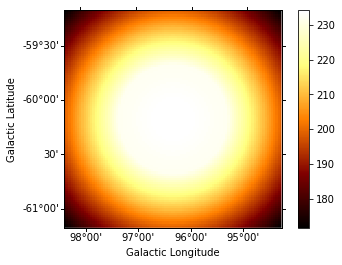

In [86]:
npred_map.sum_over_axes().plot(add_cbar=True);

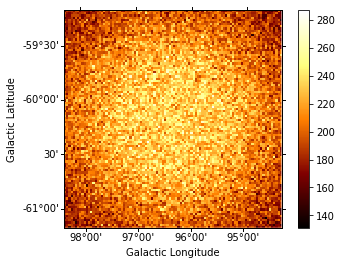

In [87]:
rng = np.random.RandomState(seed=int(time.time()))
counts = rng.poisson(npred)
counts_map = WcsNDMap(geom, counts)
counts_map.sum_over_axes().plot(add_cbar=True);

In [88]:
#def upperlimit(x):
#    result.model.parameters["scale"].value = x
#    stat = fit.total_stat(result.model.parameters)
#    lrt_val = 0.1
#    print(stat)
#    if stat<0:
#        lrt_val = 2*(stat - stat_best_fit) - 2.71
#    print("LRT", lrt_val)
#    return lrt_val

## Fit model loop

** Likelihood Ratio Function **

In [89]:
#SIGMA = 2 # 95% CI
def ts_diff(x):
    result.model.parameters["scale"].value = x
    stat = fit.total_stat(result.model.parameters)
    #likes.append(stat)
    #scales.append(x)
    #print(x, result.model.parameters["scale"].factor)
    return (stat - stat_best_fit) - 2.71

**Fit for different mDM and channels**

In [90]:
%%time
massval_list = [70, 200, 500, 5000, 10000, 50000, 100000]
channel_list = ["b"] 
NumberOfRuns = 1

# data structure
columns = ["run", "mass", "sigma_v"]
df = pd.DataFrame(columns=columns)

# loop
for run in range(NumberOfRuns):

    rng = np.random.RandomState(seed=run+int(time.time()))
    counts = rng.poisson(npred)
    counts_map = WcsNDMap(geom, counts)
    
    print('#-----------------------------------------')
    print("RUN", run+1)
    for ch in range(len(channel_list)):
        for mass in massval_list[-1:]:
            print("mass", mass)
            
            # ------- TUNE IN MODEL IN MASS/CHANNEL RANGE
            spectral_model = UserModel(
                            scale = 1,
                            mass = mass * u.GeV,
                            channel_index = ch,
                            )
            model3D = SkyModel(
                            spatial_model=spatial_model, spectral_model=spectral_model
                            )
            
            # ------- FIT TO FIXED MODEL
            model3D.parameters['lat_0'].frozen=True
            model3D.parameters['lon_0'].frozen=True
            fit = MapFit(
                model=model3D,
                counts=counts_map,
                exposure=exposure,
                background=background,
                psf=psf_kernel,
                edisp=edisp,
            )

            result = fit.run()
            pars = result.model.parameters
            stat_best_fit = fit.total_stat(pars)  # <- best likelihood
            scale_best = result.model.parameters["scale"].value
            print(scale_best)
            max_scan = scale_best + 4*result.model.parameters.error("scale")*result.model.parameters["scale"].scale
            print(result.model.parameters.error("scale")*result.model.parameters["scale"].scale)
            print(stat_best_fit)
            #likes = []
            #scales = []
#            scale_f = brentq(upperlimit, scale_best, scale_best+1000000, maxiter=100, rtol=1e-5)
            scale_f = brentq(ts_diff, scale_best, max_scan, maxiter=100, rtol=1e-5)
            sigma_v = scale_f * THERMAL_RELIC_CROSS_SECTION.value
            print(scale_f)
            #plt.plot(scales, likes)
            #plt.yscale('log')
            #plt.set_ylim(-9964897, 874642361)
            #plt.show()
            
            df = df.append(
                {"run": run, "mass": mass, "sigma_v": sigma_v},
                ignore_index=True,
            )
            print("sigma_v", sigma_v)

#-----------------------------------------
RUN 1
mass 100000
-39.81059703819769
107.45501239512365
-9369376.029731799
154.2674369818793
sigma_v 4.6280231094563794e-24
CPU times: user 7.18 s, sys: 106 ms, total: 7.29 s
Wall time: 3.73 s


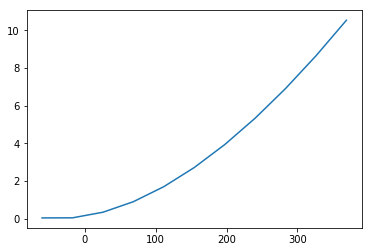

In [92]:
dic=fit.likelihood_profile("scale")
plt.plot(dic["values"],dic["likelihood"]-stat_best_fit)

In [76]:
model3D.parameters.to_table()

name,value,error,unit,min,max,frozen
str13,float64,float64,str3,float64,float64,bool
lon_0,9.634e+01,0.000e+00,deg,nan,nan,True
lat_0,-6.019e+01,0.000e+00,deg,nan,nan,True
scale,5.221e-01,1.305e-01,,0.000e+00,nan,False
mass,1.000e+05,0.000e+00,GeV,nan,nan,True
channel_index,0.000e+00,0.000e+00,,nan,nan,True


## Plot obtained results

In [55]:
df[["run"]] = df[["run"]].astype(int)
df[["mass"]] = df[["mass"]].astype(int)

stats = df.groupby(["mass"]).mean()
stats_std = df.groupby(["mass"]).std()
stats.drop(["run"], axis=1, inplace=True)
stats_std.drop(["run"], axis=1, inplace=True)
#stats_std.columns = ["std_sigma_v"]

#stats = pd.merge(stats, stats_std, left_index=True, right_index=True)
stats

,sigma_v
mass,
70,2.871925e-24
200,5.723603e-25
500,2.798699e-25
5000,3.356824e-25
10000,4.288301e-25
50000,9.889221e-25
100000,1.754982e-24


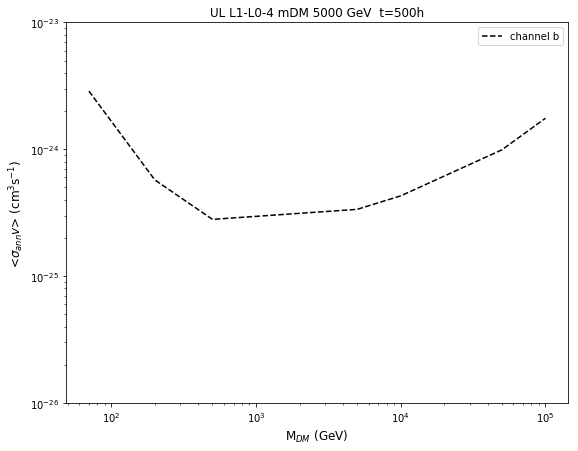

In [58]:
fig, ax1 = plt.subplots(1, figsize=(9, 7))

ax1.loglog(
    stats.index.values,
    stats["sigma_v"],
    color="k",
    ls="--",
    label='channel b'
)

ax1.set_xlabel("M$_{DM}$ (GeV)", fontsize=12)
ax1.set_ylabel(r"<$\sigma_{ann}v$> (cm$^3$s$^{-1}$)", fontsize=12)
ax1.set_ylim(1e-26, 1e-23)
ax1.set_title("UL L1-L0-4 mDM 5000 GeV  t=500h")
ax1.legend()